In [ ]:
!unzip /content/drive/MyDrive/all_files.zip 


In [ ]:
mkdir /content/home/rishi

In [ ]:
mkdir /content/home/rphatan/new_numpy_files

In [ ]:
mkdir /content/home/rphatan/new_numpy_files/face_cut

In [ ]:
mkdir /content/home/rphatan/new_numpy_files/face_cut/numpy_files

In [ ]:
rm -r /content/home/rphatan/new_numpy_files/face_cut/

In [ ]:
from keras.models import load_model
model = load_model('/content/home/rphatan/new_numpy_files/face_cut/49model.h5')

In [ ]:
import cv2

In [ ]:
width=128
height=128
img = cv2.imread('/content/home/rphatan/all_files/IXI013-HH-1212-T1_bet_7.png', 0)
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
new_resized = np.resize(resized,(1, width,height,1))

In [ ]:
new_resized.shape

(1, 128, 128, 1)

In [ ]:
a = model.predict(new_resized)
if a > 0.5 :
  print("Brain cut")
elif a < 0.5:
  print("No brain cut")

Brain cut


In [ ]:
plt.plot(np.arange(0,199),face_train_acc)
plt.plot(np.arange(0,199),face_test_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
confusion_matrix

array([[21,  2],
       [ 0,  9]])

In [ ]:
print(precision_score(y_test_, np.rint(y_pred)))
print(recall_score(y_test_, np.rint(y_pred)))
print(f1_score(y_test_,np.rint(y_pred)))



In [ ]:

import pandas as pd
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import  layers,models
from sklearn.model_selection import KFold 
import os
import sklearn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
%matplotlib inline

import matplotlib.pyplot as plt

brain_train_acc = []
brain_test_acc = []
train_losses = []
test_losses = []

val_loss = []
val_acc = []
test_acc = []


data=pd.read_csv('/content/combined.csv')

brain_votes = data['Brain-Feature-Loss'].to_list()

brain_votes_results = []
data_dir = '/content/home/rphatan/all_files'
full_2d_data = glob.glob(data_dir +'/*.png')
SEED = 220
random.seed(SEED)
random.shuffle(full_2d_data)


for index,item in enumerate(brain_votes):
  if brain_votes[index] == 'Yes':
      brain_votes_results.append(1)
  elif brain_votes[index] == 'No':
      brain_votes_results.append(0)

names = []
for i in range(len(data)):
    na = data['Filename'][i]
    na = na.split('.')[0]
    na = na + '.png'
    names.append(na)
    
    
brain_cut_dict = {}
for cur_index,files in enumerate(names):
    brain_cut_dict[files]=brain_votes_results[cur_index]

final_list=[]
for files in full_2d_data:
    key_to_search = files.split('/')[-1].strip()
    if key_to_search in brain_cut_dict:
        final_list.append([files, brain_cut_dict[key_to_search]])

k = 10
kf = KFold(n_splits=k,shuffle= True)
img_height = 128
img_width = 128
df = pd.DataFrame(final_list)
df.columns = ['name','data']
X = df['name']
y = df['data']


def build_model():
    brain_model = models.Sequential()
    brain_model.add(layers.Conv2D(8, (5, 5),strides = 2 ,activation='relu',padding='same', input_shape=(128, 128, 1)))
    brain_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    brain_model.add(layers.Conv2D(16, (3, 3),strides = 2, activation='relu',padding='same'))
    brain_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    brain_model.add(layers.Conv2D(32, (3, 3),strides = 1, activation='relu',padding='same'))
    brain_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    
    brain_model.add(layers.Flatten())
    brain_model.add(layers.Dense(32, activation='relu'))
    brain_model.add(layers.Dense(1,activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    brain_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return brain_model

def random_minibatch(train_files,batch_size):
    random_indices = np.random.choice(len(train_files), batch_size)
    return random_indices


main = []
val = []

test_indices = np.random.choice(len(final_list), int(len(final_list) * 0.2)  , replace=False)
testing_data = []

iter = 0

def model_training(train_files,validation_files,testing_data,current_k_value):
  brain_model = 0

  brain_model = build_model()

  brain_train_acc = []
  val_acc = []
  test_acc = []

  train_losses = []
  val_loss = []
  test_losses = []

  train_p = 0 
  test_p = 0

  for epoch in range(1,21,1): # BATCH SIZE IS SET TO 64.    1648 observations are go into training and validation

    for epoch_iterations in range(0,25,1):
      print(epoch*epoch_iterations)

      train_p = random_minibatch(train_files,64)
      validation_p = random_minibatch(validation_files,64)
      test_p = random_minibatch(test_indices,64)


      train_data = []
      validation_data = []
      test_data = []

      
      for i in train_p:
        train_data.append(train_files[i])

      for i in validation_p:
        validation_data.append(validation_files[i])

      for i in test_p:
        test_data.append(testing_data[i])

      


      for i in test_data:
        if i in train_data:
          print("present in train data")
        elif i in validation_data:
          print("present in validation data")
        


    # <----------------------------------------------------------------------------------------------------------->
      x_train=[]
      y_train=[]

      for files in train_data:
          image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', target_size=(img_height, img_width))
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_train.append([input_arr])
          y_train.append([files[1]])

      x_train_ = 0
      y_train_ = 0
      x_train_ = np.reshape(np.array(x_train, dtype='float32'),(len(x_train),img_height,img_width,1))
      y_train_ = np.array(y_train, dtype='float32')


    # <----------------------------------------------------------------------------------------------------------->
      x_validation=[]
      y_validation=[]

      for files in validation_data:
          image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                        target_size=(img_height, img_width))
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_validation.append([input_arr])
          y_validation.append([files[1]])

      x_validation_ = 0
      y_validation_ = 0
      x_validation_ = np.reshape(np.array(x_validation, dtype='float32'),(len(x_validation),img_height,img_width,1))
      y_validation_ = np.array(y_validation, dtype='float32')

    # <----------------------------------------------------------------------------------------------------------->
      x_test = []
      y_test = []
      for files in test_data:
          image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                        target_size=(img_height, img_width))
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_test.append([input_arr])
          y_test.append([files[1]])

      x_test_ = 0
      y_test_ = 0
      x_test_ = np.reshape(np.array(x_test, dtype='float32'),(len(x_test),img_height,img_width,1))
      y_test_ = np.array(y_test, dtype='float32')


    # <----------------------------------------------------------------------------------------------------------->

      train_loss, train_accuracy = brain_model.train_on_batch(x_train_, y_train_)
      validation_loss, validation_accuracy = brain_model.test_on_batch(x_validation_,y_validation_)
      test_loss, test_accuracy = brain_model.test_on_batch(x_test_,y_test_)

  # <----------------------------------------------------------------------------------------------------------->

      brain_train_acc.append(train_accuracy)
      train_losses.append(train_loss)
  # <----------------------------------------------------------------------------------------------------------->

      val_acc.append(validation_accuracy)
      val_loss.append(validation_loss)
  # <----------------------------------------------------------------------------------------------------------->

      test_acc.append(test_accuracy)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
      test_losses.append(test_loss)
  
  brain_model.save('/content/'+ 'current_k_value' + str(iter) +'.h5')

  return brain_train_acc,val_acc,test_acc


main_train = []
main_test = []
main_val = []
k_iter = 1

for train_index , validation_index in kf.split(X): # k different subsets of data ::::: 1484 -- training observations ::: 164 -- testing observations

  train_files = []
  validation_files = []
  testing_data = []


  for i in train_index:
    if i in test_indices:
      pass
    else:
      train_files.append(final_list[i])
  
  for i in validation_index:
    if i in test_indices:
      pass
    else:
      validation_files.append(final_list[i])

  for i in test_indices:
    testing_data.append(final_list[i])

# <----------------------------------------------------------------------------------------------------------->

  model_training_acc,model_val_acc,model_testing_acc = model_training(train_files,validation_files,testing_data,k_iter)
  main_train.append(model_training_acc)
  main_test.append(model_testing_acc)
  main_val.append(model_val_acc)


  iter += 1
  

      

In [ ]:
testing_data = []
for i in test_indices:
  testing_data.append(final_list[i])

In [ ]:

x_t = []
y_t = []
for files in testing_data:
    image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                  target_size=(img_height, img_width))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    x_t.append([input_arr])
    y_t.append([files[1]])

x_t_ = 0
y_t_ = 0
x_t_ = np.reshape(np.array(x_t, dtype='float32'),(len(x_t),img_height,img_width,1))
y_t_ = np.array(y_t, dtype='float32')


In [ ]:
from tensorflow import keras
model1 = tf.keras.models.load_model('/content/current_k_value0.h5')
model2 = tf.keras.models.load_model('/content/current_k_value1.h5')
model3 = tf.keras.models.load_model('/content/current_k_value2.h5')
model4 = tf.keras.models.load_model('/content/current_k_value3.h5')
model5 = tf.keras.models.load_model('/content/current_k_value4.h5')
model6 = tf.keras.models.load_model('/content/current_k_value5.h5')
model7 = tf.keras.models.load_model('/content/current_k_value6.h5')
model8 = tf.keras.models.load_model('/content/current_k_value7.h5')
model9 = tf.keras.models.load_model('/content/current_k_value8.h5')
model10 = tf.keras.models.load_model('/content/current_k_value9.h5')

y_pred1 = model1.predict(x_t_)
y_pred2 = model2.predict(x_t_)
y_pred3 = model3.predict(x_t_)
y_pred4 = model4.predict(x_t_)
y_pred5 = model5.predict(x_t_)
y_pred6 = model6.predict(x_t_)
y_pred7 = model7.predict(x_t_)
y_pred8 = model8.predict(x_t_)
y_pred9 = model9.predict(x_t_)
y_pred10 = model10.predict(x_t_)


confusion_matrix1 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred1))
confusion_matrix2 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred2))
confusion_matrix3 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred3))
confusion_matrix4 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred4))
confusion_matrix5 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred5))
confusion_matrix6 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred6))
confusion_matrix7 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred7))
confusion_matrix8 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred8))
confusion_matrix9 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred9))
confusion_matrix10 = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred10))

auc1 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred1))
auc2 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred2))
auc3 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred3))
auc4 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred4))
auc5 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred5))
auc6 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred6))
auc7 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred7))
auc8 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred8))
auc9 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred9))
auc10 = sklearn.metrics.roc_auc_score(y_t_, np.rint(y_pred10))

fpr1, tpr1, threshold1 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred1,2))
fpr2, tpr2, threshold2 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred2,2))
fpr3, tpr3, threshold3 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred3,2))
fpr4, tpr4, threshold4 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred4,2))
fpr5, tpr5, threshold5 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred5,2))
fpr6, tpr6, threshold6 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred6,2))
fpr7, tpr7, threshold7 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred7,2))
fpr8, tpr8, threshold8 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred8,2))
fpr9, tpr9, threshold9 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred9,2))
fpr10, tpr10, threshold10 = sklearn.metrics.roc_curve(y_t_,  np.round(y_pred10,2))



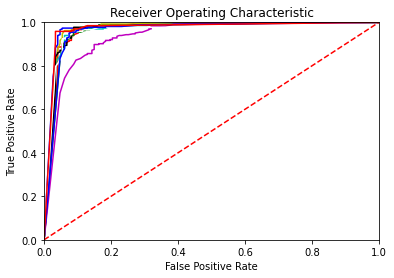

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b')
plt.plot(fpr2, tpr2, 'r')
plt.plot(fpr3, tpr3, 'g')
plt.plot(fpr4, tpr4, 'c')
plt.plot(fpr5, tpr5, 'y')
plt.plot(fpr6, tpr6, 'm')
plt.plot(fpr7, tpr7, 'k')
plt.plot(fpr8, tpr8, 'w')
plt.plot(fpr9, tpr9, 'b')
plt.plot(fpr10, tpr10, 'r')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
a = [auc1,auc2,auc3,auc4,auc5,auc6,auc7,auc8,auc9,auc10]

In [ ]:
for i in a:
  print(i)

0.9493774868437941
0.9282248748556026
0.9199075856757798
0.9384289564882557
0.9342574765755358
0.8553074059812604
0.9233346168656142
0.9305095623154923
0.9331408034912079
0.9520343986651265


In [ ]:
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred1)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred2)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred3)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred4)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred5)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred6)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred7)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred8)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred9)))
print(sklearn.metrics.accuracy_score(y_t,np.rint(y_pred10)))

print("-----------------------------------------------------------------")

print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred1)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred2)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred3)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred4)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred5)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred6)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred7)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred8)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred9)))
print(sklearn.metrics.precision_score(y_t_,np.rint(y_pred10)))
print("-----------------------------------------------------------------")
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred1)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred2)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred3)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred4)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred5)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred6)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred7)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred8)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred9)))
print(sklearn.metrics.recall_score(y_t_,np.rint(y_pred10)))

print("-----------------------------------------------------------------")
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred1)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred2)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred3)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred4)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred5)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred6)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred7)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred8)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred9)))
print(sklearn.metrics.f1_score(y_t_,np.rint(y_pred10)))

0.9563106796116505
0.9368932038834952
0.9320388349514563
0.9441747572815534
0.9466019417475728
0.8762135922330098
0.9247572815533981
0.9320388349514563
0.9393203883495146
0.9538834951456311
-----------------------------------------------------------------
0.9591078066914498
0.9442379182156134
0.9340659340659341
0.9548872180451128
0.9418181818181818
0.8848920863309353
0.9534883720930233
0.9575289575289575
0.9511278195488722
0.9694656488549618
-----------------------------------------------------------------
0.9735849056603774
0.9584905660377359
0.9622641509433962
0.9584905660377359
0.9773584905660377
0.9283018867924528
0.9283018867924528
0.9358490566037736
0.9547169811320755
0.9584905660377359
-----------------------------------------------------------------
0.9662921348314606
0.9513108614232211
0.9479553903345725
0.9566854990583805
0.9592592592592593
0.9060773480662984
0.9407265774378585
0.9465648854961831
0.9529190207156308
0.9639468690702088


In [ ]:
confusion_matrix1


array([[140,  11],
       [  4, 257]])

Text(0.5, 0, 'Observations')

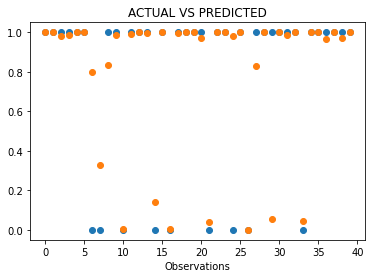

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0,40),y_t_[0:40])
plt.scatter(np.arange(0,40),y_pred7[0:40])
plt.title("ACTUAL VS PREDICTED")
plt.xlabel("Observations")


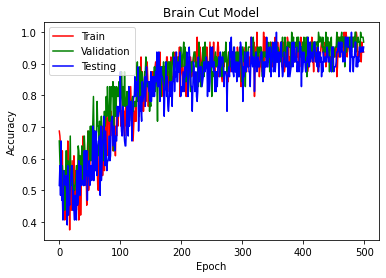

In [ ]:
plt.plot(np.arange(0,500),main_train[2],color='red')
plt.plot(np.arange(0,500),main_val[2],color='green')
plt.plot(np.arange(0,500),main_test[2],color='blue')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.title('Brain Cut Model')

plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Testing'], loc='upper left')
plt.show()

In [ ]:
main_test

In [ ]:
plt.plot(np.arange(0,500),train_losses[1],color='red')
plt.plot(np.arange(0,500),val_loss[1],color='green')
plt.plot(np.arange(0,500),test_losses[1],color='blue')

plt.title('Brain Cut Model (K = 3)')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend(['Train','Validation','Test'], loc='upper left')
plt.show()

IndexError: ignored

In [ ]:
daa = []

In [ ]:
x_t = []
y_t = []
for files in daa:
    image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                  target_size=(img_height, img_width))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    x_t.append([input_arr])
    y_t.append([files[1]])

x_t_ = 0
y_t_ = 0
x_t_ = np.reshape(np.array(x_t, dtype='float32'),(len(x_t),img_height,img_width,1))
y_t_ = np.array(y_t, dtype='float32')


In [ ]:
from tensorflow import keras
model = tf.keras.models.load_model('/content/b249.h5')
y_pred = model.predict(x_t_)

confusion_matrix = sklearn.metrics.confusion_matrix(y_t_, np.rint(y_pred))


In [ ]:
op = []

In [ ]:
test_pr = pd.DataFrame(daa)
test_pr.columns = [['name','label']]

In [ ]:
for i in range(len(y_pred)):
  op.append("{:.9f}".format(float(y_pred[i])))

test_pr['calc_prob'] = op
test_pr.to_csv('/content/top.csv',index=False)

In [ ]:
import pandas as pd
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import  layers,models
from sklearn.model_selection import KFold 
import os
import sklearn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
%matplotlib inline

import matplotlib.pyplot as plt

brain_train_acc = []
brain_test_acc = []
train_losses = []
test_losses = []

val_loss = []
val_acc = []
test_acc = []


data=pd.read_csv('/content/combined.csv')

brain_votes = data['Brain-Feature-Loss'].to_list()

brain_votes_results = []
data_dir = '/content/home/rphatan/all_files'
full_2d_data = glob.glob(data_dir +'/*.png')
SEED = 220
random.seed(SEED)
random.shuffle(full_2d_data)


for index,item in enumerate(brain_votes):
  if brain_votes[index] == 'Yes':
      brain_votes_results.append(1)
  elif brain_votes[index] == 'No':
      brain_votes_results.append(0)

names = []
for i in range(len(data)):
    na = data['Filename'][i]
    na = na.split('.')[0]
    na = na + '.png'
    names.append(na)
    
    
brain_cut_dict = {}
for cur_index,files in enumerate(names):
    brain_cut_dict[files]=brain_votes_results[cur_index]

final_list=[]
for files in full_2d_data:
    key_to_search = files.split('/')[-1].strip()
    if key_to_search in brain_cut_dict:
        final_list.append([files, brain_cut_dict[key_to_search]])


img_height = 128
img_width = 128
df = pd.DataFrame(final_list)
df.columns = ['name','data']
X = df['name']
y = df['data']


def build_model():
    brain_model = models.Sequential()
    brain_model.add(layers.Conv2D(16, (5, 5),strides = 2 ,activation='relu',padding='same', input_shape=(128, 128, 1)))
    brain_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    brain_model.add(layers.Conv2D(32, (3, 3),strides = 2, activation='relu',padding='same'))
    brain_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    brain_model.add(layers.Conv2D(64, (3, 3),strides = 1, activation='relu',padding='same'))
    brain_model.add(layers.MaxPooling2D((2, 2),padding='same'))
    
    brain_model.add(layers.Flatten())
    brain_model.add(layers.Dense(64, activation='relu'))
    brain_model.add(layers.Dense(1,activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    brain_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return brain_model

def random_minibatch(train_files,batch_size):
    random_indices = np.random.choice(len(train_files), batch_size)
    return random_indices


main = []
val = []

test_indices = np.random.choice(len(final_list), int(len(final_list) * 0.2)  , replace=False)
testing_data = []



brain_model = build_model()

def model_training(train_files,testing_data,current_k_value):
  brain_model = 0

  brain_train_acc = []
  val_acc = []
  test_acc = []

  train_losses = []
  val_loss = []
  test_losses = []

  train_p = 0 
  test_p = 0


  for epoch_iterations in range(0,20,1):

    train_p = random_minibatch(train_files,128)
    validation_p = random_minibatch(validation_files,128)
    test_p = random_minibatch(test_indices,128)


    train_data = []
    validation_data = []
    test_data = []

    
    for i in train_p:
      train_data.append(train_files[i])

    for i in validation_p:
      validation_data.append(validation_files[i])

    for i in test_p:
      test_data.append(testing_data[i])

    for i in test_data:
      if i in train_data:
        print("present in train data")
      elif i in validation_data:
        print("present in validation data")
      


  # <----------------------------------------------------------------------------------------------------------->
    
    x_train=[]
    y_train=[]

    for files in train_data:
        image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', target_size=(img_height, img_width))
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        x_train.append([input_arr])
        y_train.append([files[1]])

    x_train_ = 0
    y_train_ = 0
    x_train_ = np.reshape(np.array(x_train, dtype='float32'),(len(x_train),img_height,img_width,1))
    y_train_ = np.array(y_train, dtype='float32')


  # <----------------------------------------------------------------------------------------------------------->
    x_validation=[]
    y_validation=[]

    for files in validation_data:
        image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                      target_size=(img_height, img_width))
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        x_validation.append([input_arr])
        y_validation.append([files[1]])

    x_validation_ = 0
    y_validation_ = 0
    x_validation_ = np.reshape(np.array(x_validation, dtype='float32'),(len(x_validation),img_height,img_width,1))
    y_validation_ = np.array(y_validation, dtype='float32')

  # <----------------------------------------------------------------------------------------------------------->
    x_test = []
    y_test = []
    for files in test_data:
        image = tf.keras.preprocessing.image.load_img(files[0],color_mode = "grayscale",interpolation='nearest', 
                                                      target_size=(img_height, img_width))
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        x_test.append([input_arr])
        y_test.append([files[1]])

    x_test_ = 0
    y_test_ = 0
    x_test_ = np.reshape(np.array(x_test, dtype='float32'),(len(x_test),img_height,img_width,1))
    y_test_ = np.array(y_test, dtype='float32')


  # <----------------------------------------------------------------------------------------------------------->
    print(y_train_)
    train_loss, train_accuracy = brain_model.train_on_batch(x_train_, y_train_)
    validation_loss, validation_accuracy = brain_model.test_on_batch(x_validation_,y_validation_)
    test_loss, test_accuracy = brain_model.test_on_batch(x_test_,y_test_)

# <----------------------------------------------------------------------------------------------------------->

    brain_train_acc.append(train_accuracy)
    train_losses.append(train_loss)
# <----------------------------------------------------------------------------------------------------------->

    val_acc.append(validation_accuracy)
    val_loss.append(validation_loss)
# <----------------------------------------------------------------------------------------------------------->

    test_acc.append(test_accuracy)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    test_losses.append(test_loss)
  
  brain_model.save('/content/'+ 'current_k_value' + str(iter) +'.h5')

  return brain_train_acc,test_acc


main_train = []
main_test = []
main_val = []
k_iter = 1

for i in range(5): # k different subsets of data ::::: 1484 -- training observations ::: 164 -- testing observations

  train_files = []
  validation_files = []
  testing_data = []


  for i in range(len(final_list)):
    if i in test_indices:
      pass
    else:
      train_files.append(final_list[i])
  
  # for i in validation_index:
  #   if i in test_indices:
  #     pass
  #   else:
  #     validation_files.append(final_list[i])

  for i in test_indices:
    testing_data.append(final_list[i])

# <----------------------------------------------------------------------------------------------------------->

  model_training_acc,model_testing_acc = model_training(train_files,testing_data,k_iter)
  main_train.append(model_training_acc)
  main_test.append(model_testing_acc)
  main_val.append(model_val_acc)




[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


AttributeError: ignored

ValueError: ignored

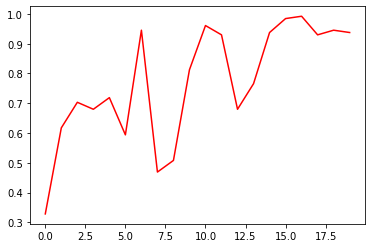

In [ ]:
plt.plot(np.arange(0,20),main_train[0],color='red')
plt.plot(np.arange(0,20),main_val[0],color='green')
plt.plot(np.arange(0,20),main_test[0],color='blue')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.title('Brain Cut Model (K = 10)')

plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Testing'], loc='upper left')
plt.show()

In [ ]:
main_train[1]

[0.4765625,
 0.625,
 0.6015625,
 0.6015625,
 0.984375,
 0.3203125,
 0.3046875,
 0.96875,
 0.9296875,
 0.671875,
 0.625,
 0.6796875,
 0.9296875,
 0.9765625,
 0.9765625,
 0.9609375,
 0.9140625,
 0.8125,
 0.875,
 0.859375]